In [1]:
import sys
from pathlib import Path
parent_dir = str(Path.cwd().parent)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import syft as sy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
np.random.seed(666)
from Distributed_CreditCard_Data import CreditCardDataLoader, Distributed_CreditCard, binary_acc
from utils_models import DigitalNN, RetailNN, FraudPrevNN

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt


dataDir = Path.cwd().parent.parent/'CreditCard/'

In [2]:
import sys
import logging

# preserve training log
so = open("config2.log", 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

In [2]:
class GovernanceNN(nn.Module):
    """Partial model for governance side
    
    Args:
        input_size (int): number of features in governance side
        governance_input (tensor): input size of governance side
    """
    def __init__(
            self,
            input_size: int = 48,
            hidden_size: int = 32,
        ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.layers_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
        )

    def forward(self, x):

        for layer in self.layers_stack:
            x = layer(x)
        return x
    
    # save weights of partial model on remote worker
    def get_weights(self):
        return self.state_dict()

class LabelOwnerNN(nn.Module):
    """Partial model for labelowner client
    
    Args:
        input_size (int): size of input from governance side
        server_input (tensor): input tensor from governance side
    """
    def __init__(
            self,
            input_size: int = 32,
            output_size: int = 2,
        ):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        
        self.out = nn.Linear(input_size, output_size)

    def forward(self, server_input):

        pred = self.out(server_input)
        return pred
    
    # save weights of partial model on remote worker
    def get_weights(self):
        return self.state_dict()
    
class SplitFraudNN(nn.Module):
    """ Split fraud neural network 
    
    Args:
        data_pointer (dict): syft data pointer
    """
    def __init__(self, models, optimizers, data_owners, server, label_owner):
        super().__init__()
        
        self.models = models
        self.optimizers = optimizers
        self.data_owners = data_owners
        self.server = server
        self.label_owner = label_owner
    
    def forward(self, data_pointer):

        #individual client's output upto their respective cut layer
        client_output = {}

        #outputs that is moved to server and subjected to concatenate for server input
        remote_output = []

        for owner in self.data_owners:
            client_output[owner.id] = self.models[owner.id](data_pointer[owner.id])
            remote_output.append(client_output[owner.id].move(self.server, requires_grad=True))
        
        # concatenate the output of individual client's output
        server_input = torch.cat(remote_output, dim=1)

        # make prediction on server model and send to the label owner client
        server_output = self.models["server"](server_input)
        server_output.move(self.label_owner, requires_grad=True)
        pred = self.models["label_owner"](server_output)
        
        return pred

    def zero_grads(self):
        for opt in self.optimizers:
            opt.zero_grad()
    
    def step(self):
        for opt in self.optimizers:
            opt.step()

    def train(self):
        for loc in self.models.keys():
            self.models[loc].train()
    
    def eval(self):
        for loc in self.models.keys():
            self.models[loc].eval()

def train(x, target, splitNN):
    
    splitNN.zero_grads()
    pred = splitNN.forward(x)
  
    criterion = nn.CrossEntropyLoss()
    loss = criterion(pred, target)
    
    #Backprop the loss on the end layer
    loss.backward()
    splitNN.step()
    
    return loss.detach().get()
        

In [4]:
digital_transaction_data = np.load(dataDir/'digital_transaction_train.npy')
retail_transaction_data = np.load(dataDir/'retail_transaction_train.npy')
fraud_prevention_data = np.load(dataDir/'fraud_prevention_train.npy')
labels = np.load(dataDir/'labels_train.npy')

train_data = CreditCardDataLoader(digital_transaction_data, retail_transaction_data, fraud_prevention_data, labels)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)

# set up virtual workers for SplitFraudNN
hook = sy.TorchHook(torch)
digital_domain = sy.VirtualWorker(hook, id="digital_domain")
retail_domain = sy.VirtualWorker(hook, id="retail_domain")
fraud_prevention_domain = sy.VirtualWorker(hook, id="fraud_prevention_domain")
server = sy.VirtualWorker(hook, id="server")
label_owner = sy.VirtualWorker(hook, id="label_owner")

data_owners = (digital_domain, retail_domain, fraud_prevention_domain)
model_locations = [digital_domain, retail_domain, fraud_prevention_domain, server, label_owner]

# set up distributed data loader for SplitFraudNN
distributed_trainloader = Distributed_CreditCard(data_owners=data_owners, data_loader=train_loader)

# set up models for SplitFraudNN
models = {
    "digital_domain": DigitalNN(input_size=digital_transaction_data.shape[1]),
    "retail_domain": RetailNN(input_size=retail_transaction_data.shape[1]),
    "fraud_prevention_domain": FraudPrevNN(input_size=fraud_prevention_data.shape[1]),
    "server": GovernanceNN(input_size=48),
    "label_owner": LabelOwnerNN(),
}

# set up optimizers for SplitFraudNN
optimizers = [
    optim.Adam(models[owner.id].parameters(), lr=1e-4) for owner in model_locations
]

for location in model_locations:
    models[location.id].send(location)

In [5]:
print(models)

epochs = 35
torch.autograd.set_detect_anomaly(True)
splitFraudNN = SplitFraudNN(models, optimizers, data_owners, server, label_owner)

for i in tqdm(range(epochs)):
    running_loss = 0.0
    splitFraudNN.train()
    for data_ptr, labels in distributed_trainloader:
        labels = labels.send(label_owner)
        loss = train(data_ptr, labels, splitFraudNN)
        running_loss += loss
    else:
        print("Epoch {} - Training loss: {}".format(i, running_loss/len(distributed_trainloader)))

{'digital_domain': DigitalNN(
  (layers_stack): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
), 'retail_domain': RetailNN(
  (layers_stack): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
), 'fraud_prevention_domain': FraudPrevNN(
  (layers_stack): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU(

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 0 - Training loss: 0.654209554195404
Epoch 1 - Training loss: 0.34311479330062866
Epoch 2 - Training loss: 0.15206921100616455
Epoch 3 - Training loss: 0.08051362633705139
Epoch 4 - Training loss: 0.05404144152998924
Epoch 5 - Training loss: 0.04013703763484955
Epoch 6 - Training loss: 0.03345117345452309
Epoch 7 - Training loss: 0.02787947468459606
Epoch 8 - Training loss: 0.024806074798107147
Epoch 9 - Training loss: 0.021849555894732475
Epoch 10 - Training loss: 0.01924460008740425
Epoch 11 - Training loss: 0.017967060208320618
Epoch 12 - Training loss: 0.016465742141008377
Epoch 13 - Training loss: 0.015761742368340492
Epoch 14 - Training loss: 0.014545582234859467
Epoch 15 - Training loss: 0.01408467162400484
Epoch 16 - Training loss: 0.013435633853077888
Epoch 17 - Training loss: 0.012758583761751652
Epoch 18 - Training loss: 0.012124480679631233
Epoch 19 - Training loss: 0.011659428477287292
Epoch 20 - Training loss: 0.010930277407169342
Epoch 21 - Training loss: 0.0109073

In [3]:
def binary_acc(y_pred, y_test):
    acc = 0.0
    
    y_pred_label = torch.softmax(y_pred, dim=1)
    _, y_pred_label = torch.max(y_pred_label, dim=1)
    correct_pred = (y_pred_label == y_test).sum()
    acc = correct_pred.item()/y_test.shape[0]
    return acc

def predict(models, dataloader, dataset_name):
    y_true = []
    y_pred = []
    test_acc = 0.0
    
    with torch.no_grad():
        for data_ptr, label in dataloader:
            output = splitFraudNN.forward(data_ptr).get()
            acc = binary_acc(output, label)
            test_acc += acc
            y_pred_label = torch.softmax(output, dim=1)
            _, y_pred_label = torch.max(y_pred_label, dim=1)
            y_pred.extend(y_pred_label.tolist())
            y_true.extend(label.long().tolist())
            
    print("Accuracy on dataset {} is ({:.3}%)".format(dataset_name, 100* test_acc/len(dataloader)))
    print(classification_report(y_true, y_pred))
    roc_auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC Score: ", roc_auc)
    
    return y_true, y_pred

Accuracy on dataset Test set is (1e+02%)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85292
           1       0.87      0.84      0.86       148

    accuracy                           1.00     85440
   macro avg       0.94      0.92      0.93     85440
weighted avg       1.00      1.00      1.00     85440

ROC AUC Score:  0.9221917774361147


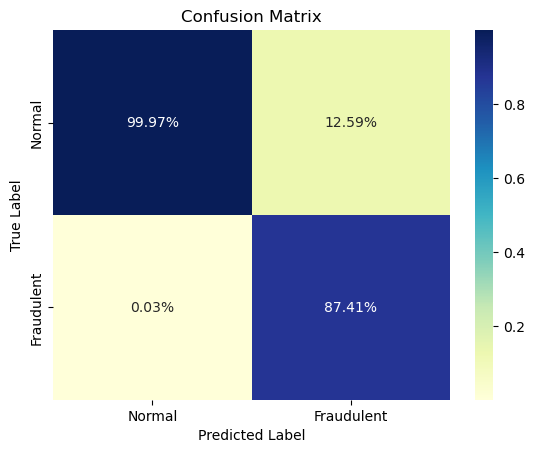

In [7]:
""" model test """
digital_transaction_test = np.load(dataDir/'digital_transaction_test.npy')
retail_transaction_test = np.load(dataDir/'retail_transaction_test.npy')
fraud_prevention_test = np.load(dataDir/'fraud_prevention_test.npy')
labels_test = np.load(dataDir/'labels_test.npy')

test_data = CreditCardDataLoader(digital_transaction_test, retail_transaction_test, fraud_prevention_test, labels_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

distributed_testloader = Distributed_CreditCard(data_owners=data_owners, data_loader=test_loader)

#Accuracy on train and test sets
splitFraudNN.eval()
# predict(models, distributed_trainloader, "Train set")
y_true, y_pred = predict(models, distributed_testloader, "Test set")

class_def = {0 : "Normal", 1 : "Fraudulent"}
cm_df = pd.DataFrame(confusion_matrix(y_true, y_pred)).rename(columns=class_def, index=class_def)
cm_df = cm_df / np.sum(cm_df)
sns.heatmap(cm_df, annot=True, fmt='0.2%', cmap="YlGnBu").set(title="Confusion Matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()

In [8]:
def save_weights(models, file_prefix):
    for loc in models.keys():
         torch.save(models[loc].get().state_dict(), f"{file_prefix}_{loc}_weights.pth")

save_weights(models, "Split_FraudNN")

##  load trained model for experiments

In [4]:
def load_weights(models, file_prefix):
    for loc in models.keys():
        model_weights = torch.load(f"{file_prefix}_{loc}_weights.pth")
        models[loc].load_state_dict(model_weights)

In [6]:
digital_transaction_test = np.load(dataDir/'digital_transaction_test.npy')
retail_transaction_test = np.load(dataDir/'retail_transaction_test.npy')
fraud_prevention_test = np.load(dataDir/'fraud_prevention_test.npy')
labels_test = np.load(dataDir/'labels_test.npy')

test_data = CreditCardDataLoader(digital_transaction_test, retail_transaction_test, fraud_prevention_test, labels_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# set up models for SplitFraudNN
models = {
    "digital_domain": DigitalNN(input_size=digital_transaction_test.shape[1]),
    "retail_domain": RetailNN(input_size=retail_transaction_test.shape[1]),
    "fraud_prevention_domain": FraudPrevNN(input_size=fraud_prevention_test.shape[1]),
    "server": GovernanceNN(input_size=48),
    "label_owner": LabelOwnerNN(),
}

# Load the weights locally
load_weights(models, "Split_FraudNN")

# set up virtual workers for SplitFraudNN
hook = sy.TorchHook(torch)
digital_domain = sy.VirtualWorker(hook, id="digital_domain")
retail_domain = sy.VirtualWorker(hook, id="retail_domain")
fraud_prevention_domain = sy.VirtualWorker(hook, id="fraud_prevention_domain")
server = sy.VirtualWorker(hook, id="server")
label_owner = sy.VirtualWorker(hook, id="label_owner")

data_owners = (digital_domain, retail_domain, fraud_prevention_domain)
model_locations = [digital_domain, retail_domain, fraud_prevention_domain, server, label_owner]

# set up distributed data loader for SplitFraudNN
distributed_testloader = Distributed_CreditCard(data_owners=data_owners, data_loader=test_loader)

# set up optimizers for SplitFraudNN
optimizers = [
    optim.Adam(models[owner.id].parameters(), lr=1e-4) for owner in model_locations
]

for location in model_locations:
    models[location.id].send(location)
    
splitFraudNN = SplitFraudNN(models, optimizers, data_owners, server, label_owner)

In [7]:
#Accuracy on train and test sets
splitFraudNN.eval()
# predict(models, distributed_trainloader, "Train set")
y_true, y_pred = predict(models, distributed_testloader, "Test set")

Accuracy on dataset Test set is (1e+02%)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85292
           1       0.87      0.84      0.86       148

    accuracy                           1.00     85440
   macro avg       0.94      0.92      0.93     85440
weighted avg       1.00      1.00      1.00     85440

ROC AUC Score:  0.9221917774361147
